In [1]:
%matplotlib notebook 
# Import modules
import math
import numpy as np
import matplotlib.pyplot
import matplotlib.ticker as mtick
from scipy.stats.stats import pearsonr 

In [2]:
T = 900  # absolute temperature in the reactor, K
R = 82.05746  # cm3 atm K-1 mol-1
R = 8.20575e-5 # m3 atm K-1 mol-1
R = 8.31446261815324e3 # L Pa mol-1 K-1
# H =  3.3e-5 # Henry's law constant for solute gas (Xe), mol(gas)/(L(sol)*atm) [Steward, 1973]
#Hxe = 4.4e-5 # mol/(m3 Pa) Sander, 2015.
# Hxe = 0.505e+8 # mol(g)/(cm3 atm) in LiF-BeF2 (64-36 mol%) at T=700C, Watson, 1962
#Kc_xe = 4.07e-4 # dimensionless, in LiF-BeF2 (64-36 mol%) at T=700C, Watson, 1962
Kc_xe = 0.057e-3  # dimensionless, in NaF-KF-LiF (46.5-11.5-42.0 mol%) at T=700C, Blander, 1959
T_ref = 700 + 273.15
H_xe = R * T_ref * 1/Kc_xe
print("Henry's law cknstant fo Xe %e" %H_xe)
#conv = 1/(1e+3/101325)    # convertion from mol(g)/(cm3 atm) to Pa L/mol
#Hxe = conv*Hxe  # Switch Henry constant to [Pa mol-1 L]
#print('Henry constant for Xe', Hxe)
# Wanna H in Pa/ (mol/L) [http://www.3rd1000.com/chem101/chem103v.htm]
# H(Kr) = 2.5e-5; H(He) = 3.7e-4
# K_L = 13.5  # Mass Transfer coefficient, ft/hr; Peebles, Figure 5 for d_bubble=0.020in
# liquid phase mass transfer coefficient i n the range of 1 < 5 < 100 f%/h [Peebles,p.9]
K_L = 100  # from Figure 3 Peebles
K_L = 0.3048*K_L/3600  #Mass Transfer coefficient m/sec 
# Must be in m/s
# for He bubble diameter d_bubble = 0:508mm (0.020in[Robertson, 3.9.1])
Q_m_L = 9.92E+6  # g/s to get 22 sec loop time
d = 0.4 # pipe diameter, m
A_C = math.pi*(d/2)**2  # contactor cross-section, m2
L = 11.1  # Length of liquid-gas contactor, m
# To m/s Q_L = Q_m_L / (4.9602*A_c)
Q_L = 1e-6*Q_m_L / 4.9602  # m3/s
Q_G = 0.02256                  # m3/s 0.02256
Q_G = 0.1                      # m3/s

# gas-liquid interfacial area per unit volume of contactor, a
d_b = 0.508e-3 # m  , 0.02 in [Peebles, 1968]
#a = 3.22e-2  # 1/m
#a = 3.11e-2  # 1/m
#a = 3.11e-2*3600/0.3048  # 1/m
a = (6/d_b) * (Q_G/(Q_G+Q_L))  # 1/m [Sada, 1987]

print(K_L, Q_L, Q_G, a*K_L, a)
alpha = (R*T*Q_L)/(H_xe*Q_G)
#alpha = (Q_L/Q_G) * Kc_xe
beta = (K_L*a*A_C*L*(1+alpha))/Q_L

eps = (1-np.exp(-beta))/(1+alpha)

print(alpha)

print("Xe removal efficiency %s" % eps)

Henry's law cknstant fo Xe 1.419512e+11
0.008466666666666667 1.9999193580903993 0.1 4.762087630400097 562.4512949291452
0.0010542656637726711
Xe removal efficiency 0.9630077293411118


In [3]:
import xml.etree.ElementTree as ET

tree = ET.parse('./eps_vs_mass_transfer_peebles.xml')
root = tree.getroot()
K_L_xml = []
eps_xml = []


for h in root.iter("point"):
    K_L_xml.append(float(h.attrib["dx"]))
    eps_xml.append(float(h.attrib["dy"]))
    
K_L_xml = 0.3048*np.array(K_L_xml, dtype=np.float64)/3600
eps_xml = np.array(eps_xml, dtype=np.float64)
print(K_L_xml)
print(eps_xml)

[8.54421922e-05 1.01830897e-04 1.24207800e-04 1.41560965e-04
 1.57120768e-04 1.74390841e-04 2.00737809e-04 2.29919823e-04
 2.55613235e-04 2.90842964e-04 3.33125094e-04 3.76534146e-04
 4.26301827e-04 4.76299146e-04 5.30400061e-04 6.03498520e-04
 7.25216385e-04 7.94334340e-04 8.52925615e-04 9.85030848e-04
 1.14514782e-03 1.37837935e-03 1.56831446e-03 1.71208729e-03
 1.97396279e-03 2.32922557e-03 2.79889389e-03 3.34658621e-03
 3.82658857e-03 4.31073025e-03 5.05283257e-03 5.72989985e-03
 6.56240915e-03 7.41700960e-03 8.46666667e-03]
[0.03229254 0.03881677 0.04735389 0.05409433 0.05979645 0.06609963
 0.07563207 0.08569005 0.09425652 0.10731981 0.12219301 0.13708522
 0.15253315 0.16805744 0.18394846 0.20772775 0.24361199 0.26316611
 0.27782476 0.31425248 0.35487091 0.41276596 0.45402286 0.48088546
 0.53156145 0.59144486 0.65806591 0.72262638 0.77040573 0.80795933
 0.85712745 0.89742737 0.92125904 0.93991061 0.96308525]


In [4]:
from scipy.optimize import curve_fit

def eps(x, r, L, alpha):
    return (1-np.exp(-2*x*r*L*alpha))  /  (1 + alpha)

# Reference data
K_L_ref = 0.3048*np.array([1, 2, 3, 5, 7, 10, 20, 50, 100])/3600  # m/sec
eps_ref = np.array([0.033, 0.065, 0.096, 0.155, 0.21, 0.285, 0.49, 0.81, 0.96])

popt, pcov = curve_fit(eps, K_L_ref, eps_ref)

print(popt, pcov)

def eps_guess(KL, H, T):
    alpha = (Q_L/Q_G)*(R*T/H)  #/ Kc
    beta = (KL*a*A_C*L*(1+alpha))/Q_L
    return (1-np.exp(-beta))/(1+alpha)



/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


[1.68164570e+02 1.71204729e+02 6.95521849e-03] [[-1.02857338e+14  1.04735394e+14 -7.42285654e-03]
 [ 1.04735394e+14 -1.06647742e+14 -5.00547932e-03]
 [-6.22487799e-03 -6.22487799e-03  5.17167495e-07]]


<IPython.core.display.Javascript object>


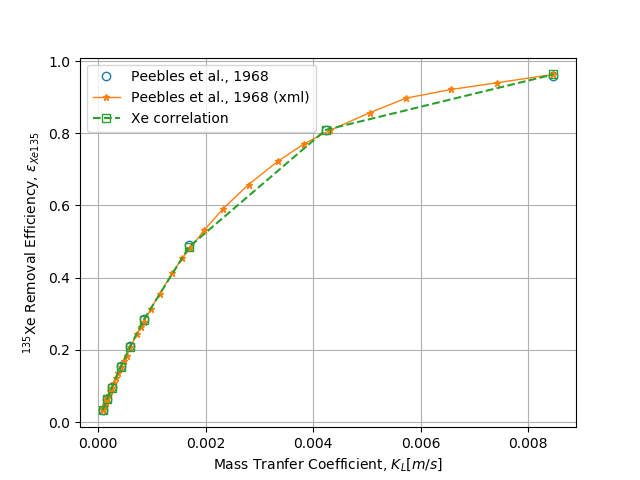

<IPython.core.display.Javascript object>


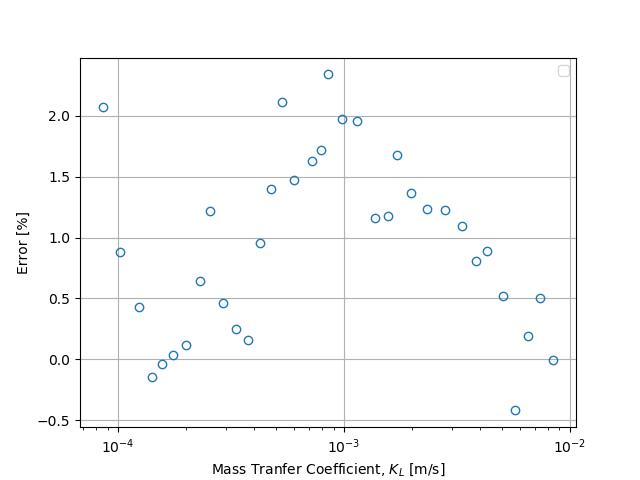

No handles with labels found to put in legend.


Mean error 0.979386 % +- 0.723919 %
(0.9999576778205437, 8.802914967496972e-69)
Correlation between reported and fitted removal efficency is 0.9999576778


In [5]:
rel_error = 100*(eps_guess(K_L_xml, H_xe, 900) - eps_xml)/eps_xml

# Initialize figure
fig_1 = matplotlib.pyplot.figure(1)
ax = fig_1.add_subplot(111)
ax.grid(True)

ax.plot(K_L_ref, eps_ref, 'o', label='Peebles et al., 1968', linewidth=1.5, markerfacecolor="None")
ax.plot(K_L_xml, eps_xml, '*-', label='Peebles et al., 1968 (xml)', linewidth=1.0, markersize=5)
#ax.loglog(K_L_ref, eps(K_L_ref, *popt),  'r-', label=r'fit: r=%5.3fcm, L=%5.3fcm, $\alpha$=%5.10f' % tuple(popt))

ax.plot(K_L_ref, eps_guess(K_L_ref, H_xe, 900),  's--', label='Xe correlation', markerfacecolor="None")
#ax.plot(K_L_ref, eps_guess(K_L_ref, H_he, 900),  's--', label='He Kc', markerfacecolor="None")

ax.set_ylabel(r'$^{135}$Xe Removal Efficiency, $\epsilon_{Xe135}$')
ax.set_xlabel(r'Mass Tranfer Coefficient, $K_L [m/s]$')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')

ax.legend(loc=0)

fig_1.show()

# Initialize figure
fig_e = matplotlib.pyplot.figure(2)
ax = fig_e.add_subplot(111)
ax.grid(True)
ax.semilogx(K_L_xml, rel_error, 'o', linewidth=1.5, markerfacecolor="None")
ax.set_ylabel(r'Error [%]')
ax.set_xlabel(r'Mass Tranfer Coefficient, $K_L$ [m/s]')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')

ax.legend(loc=0)

fig_e.show()
print(r"Mean error %f %% +- %f %%" % (np.mean(abs(rel_error)), np.std(rel_error)))
print(pearsonr(eps_xml, eps_guess(K_L_xml, H_xe, 900)))
print ("Correlation between reported and fitted removal efficency is %.10f"
           % pearsonr(eps_xml, eps_guess(K_L_xml, H_xe, 900))[0])

## Calculation of constant but realisitc epsilon for dissertation

In [8]:
# AN AXIAL-FLOW CENTRIFUGAL GAS BUBBLE SEPARATOR [Gabbard, 1974]
# The separation efficiency at design flow rates varied between 80% and 95% depending
# on the bubble diameter and test fluid.
eps_es = 0.95  # [-], assume separator can remove 95%
T = 900       # [K], temperature of the salt
V_salt = 44.35305  # [m3]

R = 8.31446261815324e3 # L Pa mol-1 K-1

# Case 1, eps~0.91
K_L = 0.3048*100/3600  # [m/s] maximum possible transfer coefficient according Peebles, 1968
# Case 2, eps~0.5
#K_L = 0.3048*25/3600  # [m/s] just possible transfer coefficient according Peebles, 1968
# Case 3, eps~0.031, minimal
#K_L = 0.3048*1/3600  # [m/s] minimum possible transfer coefficient according Peebles, 1968

T_ref = 700 + 273.15
Kc_xe = 0.057e-3  # dimensionless, in NaF-KF-LiF (46.5-11.5-42.0 mol%) at T=700C, Blander, 1959
H_xe = R * T_ref * 1/Kc_xe # [Pa mol-1 L] for [Xe] Henry's law constant

Kc_kr = 0.283e-3  # 'between Ar and Xe' dimensionless, in NaF-KF-LiF (46.5-11.5-42.0 mol%) at T=700C, Blander, 1959
H_kr = R * T_ref * 1/(Kc_kr) # [Pa mol-1 L] for [Kr] Henry's law constant

Kc_h = 3.87e-3  # dimensionless (+/-0.37), in Li2BeF4 at T=700C, tomkins_gases_2016
H_h = R* T_ref * 1/Kc_h

Q_m_L = 9.92E+6         # g/s to get 22 sec loop time
d = 0.4                 # pipe diameter, m
A_C = math.pi*(d/2)**2  # contactor cross-section, m2
L = 11.1                  # Length of liquid-gas contactor, m
# To m/s Q_L = Q_m_L / (4.9602*A_c)
Q_L = 1e-6*Q_m_L / 4.9602  # m3/s
Q_He = 0.1                 # m3/s 0.02256
# gas-liquid interfacial area per unit volume of contactor, a
d_b = 0.508e-3 # m  , 0.02 in [Peebles, 1968] (0.020in[Robertson, 3.9.1])

a = (6/d_b) * (Q_He/(Q_He+Q_L))  # 1/m [Sada, 1987]

print(K_L, Q_L, Q_He, a, H_xe)
print('Volumetric mass transfer coefficient %f 1/s' %(a*K_L))
def eps(H):
    alpha = (R*T*Q_L)/(H*Q_He)
    beta = (K_L*a*A_C*L*(1+alpha))/Q_L
    return (1-np.exp(-beta))/(1+alpha)


eps_s_xe = eps(H_xe)
eps_s_kr = eps(H_kr)
eps_s_h = eps(H_h)

# 0.96308525
print("Xe migration efficiency in the sparger %s" % eps_s_xe)
print("Kr migration efficiency in the sparger %s" % eps_s_kr)
print("H2 migration efficiency in the sparger %s" % eps_s_h)
print("\n\nXe total separation efficiency %s" % (eps_s_xe*eps_es))
print("Kr total separation efficiency %s" % (eps_s_kr*eps_es))
print("H2 total separation efficiency %s" % (eps_s_h*eps_es))

0.008466666666666667 1.9999193580903993 0.1 562.4512949291452 141951215734.3127
Volumetric mass transfer coefficient 4.762088 1/s
Xe migration efficiency in the sparger 0.9630077293411118
Kr migration efficiency in the sparger 0.9594967048317221
H2 migration efficiency in the sparger 0.9066395505691143


Xe total separation efficiency 0.9148573428740562
Kr total separation efficiency 0.9115218695901359
H2 total separation efficiency 0.8613075730406585


In [ ]:
V_b = (4/3)*math.pi* (d_b/2)**3
B_he = Q_He/V_b   # bubbles/sec
print(V_b)
print("He bubbles in the pipeline contactor %e bubbles/s" %B_he)
# Formula for dissertation: sum 1.456835e+09*(1-0.9)^n, n=1 to infinity
he = 0.0 # number of bubbles in the salt at the beginning
dt = 1  # s
for i in range(1, 20):  # iterate over seconds
    t = dt*i
    he = (he+B_he*dt)*(1-eps_es)   # 95% of bubbles are being removed by centrifugal separator every second
    print("Time %fs; %e bubbles in the salt; void fraction is %f %%" %(t,he/dt, 100*he*V_b/V_salt/dt))

## He Void fraction study

In [ ]:
rho_salt = 4.9602  # g/cc
rho_he = 5.26e-5   # g/cc at T=900K
void_percent = 0.011867/100  # fraction of 0.011867% see above
void_percent = 0.2/100  # fraction of 5% see above

void_percent = np.arange(0, 1.1, 0.1)/100
print(100*void_percent)
rho_mix = (1-void_percent)*rho_salt + void_percent * rho_he

print("Density of the salt+He bubbles [g/cm3]", rho_mix)
#print("2004.09c -%.14e" %(rho_he*void_percent/rho_salt))

## Reactivity change due to void insertion

In [ ]:
void_percent = [0, 0.011867, 0.2, 0.5, 1, 5]   # [%]
keff = [1.03636, 1.03640, 1.03662, 1.03707, 1.03788, 1.04417]
keff_std = [7, 6, 6, 7, 7]

# Initialize figure
fig_3 = matplotlib.pyplot.figure(3)
ax = fig_3.add_subplot(111)
ax.grid(True)
ax.plot(void_percent, keff, 'o-', linewidth=1.5, markerfacecolor="None")
ax.set_ylabel(r'$k_{eff}$')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))
ax.set_xlabel(r'He volume fraction [%]')
#ax.set_xlim(0, 1)
#ax.set_ylim(1.036, 1.038)
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
#ax.legend(loc=0)

fig_3.show()

In [ ]:
import itertools
def volume(He, eps, K_L, d_b):
    nom = d_b*H_xe*Q_L*(He+Q_L)*np.log(-He*H_xe/((He*H_xe*(eps-1)+R*T*Q_L*eps)))
    den = 6*K_L*(He*H_xe+R*T*Q_L)
    return nom/den

Q_He = np.linspace(0.00, 1.0, num=10000)  # m3/s
# Initialize figure
fig_4 = matplotlib.pyplot.figure(4)
ax = fig_4.add_subplot(111)
ax.grid(True)
K_L = 0.3048*100/3600
style = itertools.cycle(('-', '-', '--', '-', '-', '-'))
for d_b in [0.508e-4, 0.25e-3, 0.508e-3, 1e-3, 2e-3, 5.08e-3]:
    s=next(style)
    ax.plot(Q_He, volume(Q_He, eps_guess(K_L, H_xe, 900), K_L, d_b),
            linestyle=s, linewidth=1.5, markerfacecolor="None", label=r'$d_{b}$=%.3fmm' %(d_b*1e3))
ax.set_ylabel(r'Contactor volume $V$ [$m^3$]')
ax.set_xlabel(r'Helium injection volume flow rate [$m^3/s$]')
ax.set_xlim(0.001, 0.25)
ax.set_ylim(0, 25)
ax.legend(loc=0)
ax.set_title(r'Contactor size as a function of helium volumetric'
              '\n'
             r'flow rate for $K_L$=%fm/s and $\epsilon=%f$' % (K_L,eps_guess(K_L, H_xe, 900)))
fig_4.show()
#fig_4.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/contactor_v_vs_he_q.png',bbox_inches='tight', dpi=700)

# Initialize figure
fig_5 = matplotlib.pyplot.figure(5)
ax = fig_5.add_subplot(111)
ax.grid(True)
K_L = 0.3048*100/3600
style = itertools.cycle(('-', '-', '--', '-', '-', '-'))
for d_b in [0.508e-4, 0.25e-3, 0.508e-3, 1e-3, 2e-3, 5.08e-3]:
    s=next(style)
    ax.loglog(Q_He, volume(Q_He, eps_guess(K_L, H_xe, 900), K_L, d_b),
            linestyle=s, linewidth=1.5, markerfacecolor="None", label=r'$d_{b}$=%.3fmm' %(d_b*1e3))
ax.set_ylabel(r'Contactor volume $V$ [$m^3$]')
ax.set_xlabel(r'Helium injection volume flow rate [$m^3/s$]')
ax.set_xlim(0.01, 1.0)
ax.set_ylim(0, 100)
ax.legend(loc=0)
ax.set_title(r'Contactor size as a function of helium volumetric'
              '\n'
             r'flow rate for $K_L$=%fm/s and $\epsilon=%f$' % (K_L,eps_guess(K_L, H_xe, 900)))
fig_5.show()
#fig_5.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/contactor_v_vs_he_q_loglog.png',bbox_inches='tight', dpi=700)